# HOTRG (cytnx version)
## Demo-5
* Author: Pochung Chen
* Last update: 2022/5/29
* Α α, Β β, Γ γ, Δ δ, Ε ε, Ζ ζ, Η η, Θ θ, Ι ι, Κ κ, Λ λ, Μ μ, Ν ν, Ξ ξ, Ο ο, Π π, Ρ ρ, Σ σ/ς, Τ τ, Υ υ, Φ φ, Χ χ, Ψ ψ, and Ω ω

Two site Hamiltonian: 
$$ \large
  E(s_1, s_2) = -Js_1 s_2
$$

Boltzmann weight on the bond:
$$ \large
  W = e^{-\beta E} = 
  \left[ \begin{array}{cc}
  e^{+\beta J} & e^{-\beta J} \\
  e^{-\beta J} & e^{+\beta J}
  \end{array} \right]
$$

Decompose $W$ as $M M^\dagger$, where
$$ \large
  W = e^{-\beta E} = M M^\dagger,
  M = 
  \left[ \begin{array}{cc}
  +\sqrt{\cosh{\beta J}} & +\sqrt{\sinh{\beta J}} \\
  +\sqrt{\cosh{\beta J}} & -\sqrt{\sinh{\beta J}}
  \end{array} \right]
$$

Numerically, we first perform SVD on $W$ to obtain $M$ and $M^\dagger$:
$$ \large
  W = U S V^\dagger \rightarrow
  M = U \sqrt{S}, M^\dagger = \sqrt{S} U^\dagger.
$$
Note that because $W$ is Hermitian, on has $V=U$.

$$ \large
  T_{ijkl} = \sum_\alpha
  M_{\alpha, i} M_{\alpha, j} M_{\alpha, k} M_{\alpha, l}
$$

$$ \large
  T_c = \frac{2}{\log(1+\sqrt{2})} \approx 2.269.
$$

## Cytnx cheat sheet

* numpy <-> cytnx.tensor <-> cytnx.UniTensor

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cytnx

In [2]:
Tc = 2./np.log(1.+np.sqrt(2))
print(Tc)
def ut_print(ut):
    ut.print_diagram()
    print(ut.get_block().numpy())

2.269185314213022


## Constrauct $M$

In [3]:
def M0_(T):
    M0 = np.array([[+np.sqrt(np.cosh(1/T)), +np.sqrt(np.sinh(1/T))],
                   [+np.sqrt(np.cosh(1/T)), -np.sqrt(np.sinh(1/T))]])
    return M0

def M_(T,h):
    W = np.array([[np.exp(1/T), np.exp(-1/T)],
                  [np.exp(-1/T), np.exp(1/T)]])
    W = cytnx.from_numpy(W)
    # S, U, Vd = cytnx.linalg.Svd(W)
    S, U, Vd = W.Svd()
    M = U @ cytnx.linalg.Diag(S.Pow(0.5))
    Md = cytnx.linalg.Diag(S.Pow(0.5)) @ Vd
    M = cytnx.UniTensor(M, rowrank=1)
    M.set_name('M')
    Md = cytnx.UniTensor(Md, rowrank=1)
    Md.set_name('M†')    
    return M, Md

## Construct $T_{bare}$

In [4]:
def delta_():
    delta = cytnx.zeros([2,2,2,2])
    delta[0,0,0,0]= 1.0
    delta[1,1,1,1]= 1.0
    delta = cytnx.UniTensor(delta, rowrank=2)
    delta.set_name('ẟ')
    return delta

def T_bare_(T, h):
    ut_M, ut_Md = M_(T, h)
    ut_delta = delta_()
    Ising_net = cytnx.Network('Networks/Ising_square.net')
    Ising_net.PutUniTensors(['delta', 'M0.d', 'M1.d', 'M2', 'M3'],
                            [ut_delta, ut_Md, ut_Md, ut_M, ut_M])
    T_bare = Ising_net.Launch(optimal=True)
    T_bare.set_name('T_bare')
    return T_bare

def ymerge(Tu, Td):
    ymerge_net = cytnx.Network('Networks/merge_two_y.net')
    ymerge_net.PutUniTensors(['Tu', 'Td'], [Tu, Td])
    Tud = ymerge_net.Launch(optimal=True)
    Tud.combineBonds([1,2])
    Tud.combineBonds([3,4])
    return Tud
    
def ymerge_TM(Tu, Td):
    ymerge_net_TM = cytnx.Network('Networks/merge_two_y_trace.net')
    ymerge_net_TM.PutUniTensors(['Tu', 'Td'], [Tu, Td])
    TMud = ymerge_net_TM.Launch(optimal=True)
    TMud.combineBonds([1,2])
    TMud.combineBonds([3,4])
    TMud = TMud.get_block()
    return TMud

def xmerge(Tl, Tr):
    xmerge_net = cytnx.Network('Networks/merge_two_x.net')
    xmerge_net.PutUniTensors(['Tl', 'Tr'], [Tl, Tr])
    Tlr = xmerge_net.Launch(optimal=True)
    Tlr.combineBonds([0,1])
    Tlr.combineBonds([4,5])
    return Tlr

def xmerge_TM(Tl, Tr):
    xmerge_net_TM = cytnx.Network('Networks/merge_two_x_trace.net')
    xmerge_net_TM.PutUniTensors(['Tl', 'Tr'], [Tl, Tr])
    TMlr = xmerge_net_TM.Launch(optimal=True)
    # TMlr.print_diagram()
    # TMlr.combineBonds([0,1])
    # TMlr.combineBonds([4,5])
    return TMlr

def T_to_TM(T):
    trace_net = cytnx.Network('Networks/trace_y.net')
    dim = T.shape()[0]
    trace_net.PutUniTensors(['T', 'Id'], [T, cytnx.UniTensor(cytnx.eye(dim), rowrank=1)])
    TM = trace_net.Launch(optimal=True)
    TM = TM.get_block()
    return TM

## Transfer Matrix
* TM$[(L_x, L_y)]$ = TrT$[(L_x, L_y)]$.
* TM$[(L_x, L_y)]$ = Transfer Matrix of $L_x$ columns, each column has $L_y$ sites. 
* $\lambda_i(L_x, L_y)$ = Eigenvalues of TM$[(L_x, L_y)]$.
* $E_i(Lx, Ly) = -\ln \lambda_i(L_x, L_y)$.
* $\lambda_i(L_y, L_y)=\lambda_i(1, L_y)^{L_x}$
* $E_i(L_y, L_y) = L_x E_i(1, L_y)$

Correlation length $\xi$ for an infinite strip (in x-direction) of width $L_y$
$$ \large
  \xi(L_y)=\frac{1}{E_1(1,L_y)-E_0(1,L_y)}.
$$

$$ \large
  \frac{\xi(L_y)}{L_y}
  =\frac{1}{[E_1(1,L_y)-E_0(1,L_y)]L_y}
  =\frac{L_x}{[E_1(L_x,L_y)-E_0(L_x,L_y)]L_y}.
$$

For $L = L_x = L_y$
$$ \large
  \frac{\xi(L)}{L}
  =\frac{1}{E_1(L,L)-E_0(L,L)}.
$$


## Merge

Linear growth in y-direction:
* T[(1, Ly)], T[(1, 1)] -->ymerge--> T[(1, Ly+1)] 

Power law growth in both directionx:
* T[(1, 1)], T[(1, 1)] -->ymerge--> T[(1, 2)]
* T[(1, 2)], T[(1, 2)] -->xmerge--> T[(2, 2)]
* T[(2, 2)], T[(2, 2)] -->ymerge--> T[(2, 4)]
* T[(2, 4)], T[(2, 4)] -->xmerge--> T[(4, 4)]

## Single temperature, various sizes (linear growth)

In [5]:
T = {}
TM = {}
λ = {}
E = {}
temp = 1.0
h = 0.0

T[(1,0)] = T_bare_(temp, h)
T[(1,1)] = T_bare_(temp, h)

Lx = 1
for Ly in range(2, 10+1):
    # print('=====(Lx, Ly) =', (Lx, Ly))
    T[(Lx, Ly)] = ymerge(T[(Lx, Ly-1)], T[(Lx, 1)])
    TM[(Lx, Ly)] = ymerge_TM(T[(Lx, Ly-1)], T[(Lx, 1)])
    λ[(Lx, Ly)], _ = cytnx.linalg.Eigh(TM[(Lx, Ly)])
    λ[(Lx, Ly)] = λ[(Lx, Ly)].numpy()[::-1]
    # print('λ =\n', λ[(Lx, Ly)][:4])
    E[(Lx, Ly)] = -np.log(λ[(Lx, Ly)])
    print('E([(1, {})]/{}='.format(Ly, Ly), E[(Lx, Ly)][:4]/Ly)    

E([(1, 2)]/2= [-2.00973273 -1.99075728  0.00924272  0.02821817]
E([(1, 3)]/3= [-2.00126516 -1.99942807 -0.73769655 -0.70281419]
E([(1, 4)]/4= [-2.0004515  -2.000245   -1.08572752 -1.05884264]
E([(1, 5)]/5= [-2.000361   -2.00033556 -1.28225675 -1.26433492]
E([(1, 6)]/6= [-2.00034995 -2.00034661 -1.40848869 -1.39651137]
E([(1, 7)]/7= [-2.00034851 -2.00034805 -1.49654367 -1.48831006]
E([(1, 8)]/8= [-2.00034832 -2.00034825 -1.56155163 -1.55570994]
E([(1, 9)]/9= [-2.00034829 -2.00034828 -1.61156295 -1.60729433]
E([(1, 10)]/10= [-2.00034828 -2.00034828 -1.65125815 -1.64805637]


## Single temperature, various sizes (power law growth)

In [6]:
T = {}
TM = {}
λ = {}
E = {}
temp = 1.0
h = 0.0

##### T[(1,2)]
T[(1,1)] = T_bare_(temp, h)
T[(1,2)] = ymerge(T[(1,1)], T[(1,1)])
TM[(1,2)] = T_to_TM(T[(1,2)])
λ[(1,2)], _ = cytnx.linalg.Eigh(TM[(1,2)])
λ[(1,2)] = λ[(1,2)].numpy()[::-1]
E[(1,2)] = -np.log(λ[(1,2)])
print('E[(1,2)]/1/2=', E[(1,2)][:4]/1/2)

##### T[(2,2)]
T[(2,2)] = xmerge(T[(1,2)], T[(1,2)])
TM[(2,2)] = T_to_TM(T[(2,2)])
λ[(2,2)], _ = cytnx.linalg.Eigh(TM[(2,2)])
λ[(2,2)] = λ[(2,2)].numpy()[::-1]
E[(2,2)] = -np.log(λ[(2,2)])
print('E[(2,2)]/2/2=', E[(2,2)][:4]/2/2)

##### T[(2,4)]
T[(2,4)] = ymerge(T[(2,2)], T[(2,2)])
TM[(2,4)] = T_to_TM(T[(2,4)])
λ[(2,4)], _ = cytnx.linalg.Eigh(TM[(2,4)])
λ[(2,4)] = λ[(2,4)].numpy()[::-1]
E[(2,4)] = -np.log(λ[(2,4)])
print('E[(2,4)]/2/4=', E[(2,4)][:4]/2/4)

##### T[(4,4)]
T[(4,4)] = xmerge(T[(2,4)], T[(2,4)])
TM[(4,4)] = T_to_TM(T[(4,4)])
λ[(4,4)], _ = cytnx.linalg.Eigh(TM[(4,4)])
λ[(4,4)] = λ[(4,4)].numpy()[::-1]
E[(4,4)] = -np.log(λ[(4,4)])
print('E[(4,4)]/4/4=', E[(4,4)][:4]/4/4)

E[(1,2)]/1/2= [-2.00973273 -1.99075728  0.00924272  0.02821817]
E[(2,2)]/2/2= [-2.00973273 -1.99075728  0.00924272  0.02821817]
E[(2,4)]/2/4= [-2.0004515  -2.000245   -1.08572752 -1.05884264]
E[(4,4)]/4/4= [-2.0004515  -2.000245   -1.08572752 -1.05884264]


## Various temperatures, various sizes (linear growth)

In [7]:
h = 0.0
temp_range = np.linspace(2.2, 2.4, 41)
L_range = range(2, 10+1)

λ = {}
E = {}
λ0 = {}
λ1 = {}
E0 = {}
E1 = {}

Lx = 1
for Ly in L_range:
    λ0[(Lx, Ly)] = np.zeros_like(temp_range)
    λ1[(Lx, Ly)] = np.zeros_like(temp_range)
    E0[(Lx, Ly)] = np.zeros_like(temp_range)
    E1[(Lx, Ly)] = np.zeros_like(temp_range)

for i, temp in enumerate(temp_range):
    # print(i, temp)
    T = {}
    TM = {}
    
    T[(1,0)] = T_bare_(temp, h)
    T[(1,1)] = T_bare_(temp, h)
    
    for Ly in L_range:
        # print('(Lx, Ly) =', (Lx, Ly))
        T[(Lx, Ly)] = ymerge(T[(Lx, Ly-1)], T[(Lx, 1)])
        TM[(Lx, Ly)] = T_to_TM(T[(Lx, Ly)])
        λ[(Lx, Ly)], _ = cytnx.linalg.Eigh(TM[(Lx, Ly)])
        λ[(Lx, Ly)] = λ[(Lx, Ly)].numpy()[::-1]
        E[(Lx, Ly)] = -np.log(λ[(Lx, Ly)])
        λ0[(Lx, Ly)][i] = λ[(Lx, Ly)][0]
        λ1[(Lx, Ly)][i] = λ[(Lx, Ly)][1]
        E0[(Lx, Ly)][i] = E[(Lx, Ly)][0]
        E1[(Lx, Ly)][i] = E[(Lx, Ly)][1]

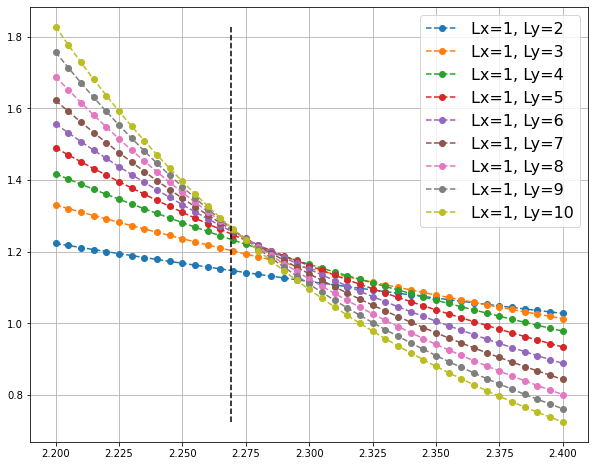

In [8]:
fig, ax = plt.subplots(figsize=(10,8))

Lx = 1
for Ly in L_range:
    ax.plot(temp_range, 1/((E1[(Lx,Ly)]-E0[(Lx,Ly)])*Ly), 'o--', label='Lx=1, Ly={}'.format(Ly))

ax.plot([Tc, Tc], [np.min(1/((E1[(Lx,Ly)]-E0[(Lx,Ly)])*Ly)), np.max(1/((E1[(Lx,Ly)]-E0[(Lx,Ly)])*Ly))],'k--')
# ax.set_xlim(2.25, 2.30)
# ax.set_ylim(1.15, 1.35)
ax.legend(fontsize=16)
ax.grid()

## Various temperatures, various sizes (power law growth)

In [14]:
temp_range = np.linspace(2.2, 2.4, 41)

for L in [1,2,4]:
    λ0[(L, L)] = np.zeros_like(temp_range)
    λ1[(L, L)] = np.zeros_like(temp_range)
    E0[(L, L)] = np.zeros_like(temp_range)
    E1[(L, L)] = np.zeros_like(temp_range)

for i, temp in enumerate(temp_range):
    T = {}
    TM = {}
    T[(1,1)] = T_bare_(temp, h)
    
    for L in [1,2]:
        # print((2*L, 2*L))
        T[(L, 2*L)] = ymerge(T[(L, L)], T[(L, L)])
        T[(2*L, 2*L)] = xmerge(T[(L, 2*L)], T[(L, 2*L)])
        TM[(2*L, 2*L)] =T_to_TM(T[(2*L, 2*L)])
        λ[(2*L, 2*L)], _ = cytnx.linalg.Eigh(TM[(2*L, 2*L)])
        λ[(2*L, 2*L)] = λ[(2*L, 2*L)].numpy()[::-1]
        E[(2*L, 2*L)] = -np.log(λ[(2*L, 2*L)])
        λ0[(2*L, 2*L)][i] = λ[(2*L, 2*L)][0]
        λ1[(2*L, 2*L)][i] = λ[(2*L, 2*L)][1]
        E0[(2*L, 2*L)][i] = E[(2*L, 2*L)][0]
        E1[(2*L, 2*L)][i] = E[(2*L, 2*L)][1]

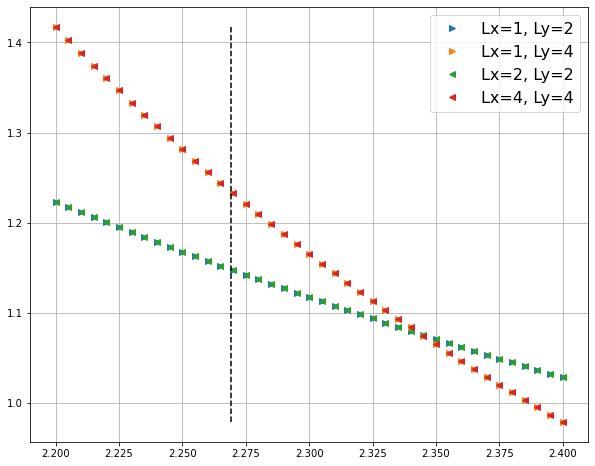

In [19]:
fig, ax = plt.subplots(figsize=(10,8))

Lx = 1
for Ly in [2, 4]:
    ax.plot(np.linspace(2.2, 2.4, 41), 1/((E1[(Lx,Ly)]-E0[(Lx,Ly)])*Ly), '>', label='Lx=1, Ly={}'.format(Ly))

for L in [2,4]:
    ax.plot(temp_range, 1/((E1[(L,L)]-E0[(L,L)])), '<', label='Lx={}, Ly={}'.format(L, L))

ax.plot([Tc, Tc], [np.min(1/((E1[(L,L)]-E0[(L,L)]))), np.max(1/((E1[(L,L)]-E0[(L,L)])))],'k--')
# ax.set_xlim(2.25, 2.30)
# ax.set_ylim(1.15, 1.35)
ax.legend(fontsize=16)
ax.grid()